In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
model_path = r"C:\Users\Ekaansh\OneDrive\Desktop\AB\vs code\JS\projects\satelite\test 2\eurosat_resnet18.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # adjust to your number of classes
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_9520\3719569539.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_path = r"D:\datasets\2750\2750\Pasture\Pasture_2.jpg"
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

In [7]:
gradients = []
activations = []

def forward_hook(module, input, output):
    activations.append(output.detach())

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0].detach())

target_layer = model.layer3
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward & backward
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()
model.zero_grad()
output[0, pred_class].backward()

# Get heatmap
grads = gradients[0]  # [batch, channels, h, w]
acts = activations[0]  # [batch, channels, h, w]
weights = grads.mean(dim=(2, 3), keepdim=True)  # [batch, channels, 1, 1]
cam = (weights * acts).sum(dim=1)  # [batch, h, w]
cam = torch.relu(cam)
cam = cam[0].cpu().numpy()
cam = cv2.resize(cam, (img.width, img.height))
cam = cam - cam.min()
cam = cam / cam.max()


c:\Users\Ekaansh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [8]:
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.array(img), 0.5, heatmap, 0.5, 0)

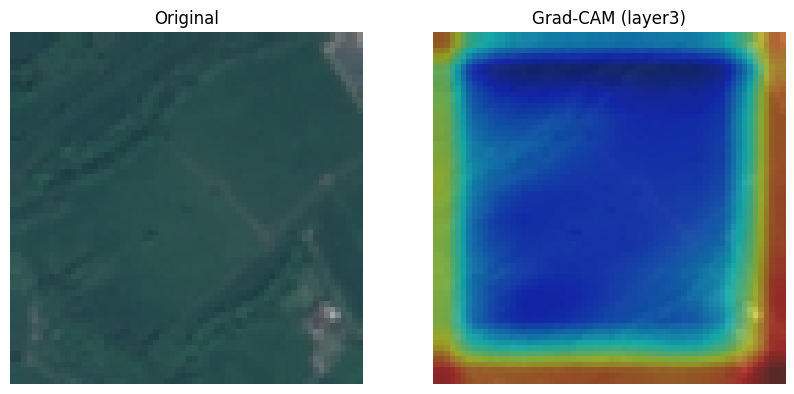

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM (layer3)")
plt.imshow(overlay)
plt.axis("off")
plt.show()